In [9]:
import os
import ee
import geemap
from IPython.display import display, clear_output, Image
from geemap import cartoee
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

In [10]:
# After executing this line of code for the first use, you can get the authentication number linked to Google.
#Map = geemap.Map()
# Authenticate the Google earth engine with google account
ee.Initialize() 
Map = geemap.Map()

In [11]:
def lst_filter(image):
    
    qaday = image.select(['QC_Day']); 
    qanight = image.select(['QC_Night']); 
    dayshift = qaday.rightShift(6);
    nightshift = qanight.rightShift(6);
    daymask = dayshift.lte(2);
    nightmask = nightshift.lte(2);
    #dayshift1 = qaday.leftShift(6);
    #dayshift2 = qaday.rightShift(6);
    #daymask = dayshift2.eq(0);
    #nightshift1 = qanight.leftShift(6);
    #nightshift2 = qanight.rightShift(6);
    #nightmask = nightshift2.eq(0);  
    outimage = ee.Image(image.select(['LST_Day_1km', 'LST_Night_1km']));
    outmask = ee.Image([daymask, nightmask]);
    return outimage.updateMask(outmask); 

def lst_day(image):
    
    lst_day = image.select('LST_Day_1km').multiply(0.02).subtract(273.15).rename("lst_day")
    image = image.addBands(lst_day)

    return(image)

def lst_night(image):
    
    lst_night = image.select('LST_Night_1km').multiply(0.02).subtract(273.15).rename("lst_night")
    image = image.addBands(lst_night)

    return(image)

def lst_mean(image):
    lst_mean = image.expression(
    '(day + night) / 2', {
    'day': image.select('lst_day'),
    'night': image.select('lst_night')}).rename('lst_mean');

    return image.addBands(lst_mean);

In [12]:
dataset = ee.ImageCollection('MODIS/006/MOD11A2') \
            .filter(ee.Filter.date('2021-01-01','2021-12-31')) \
            .map(lst_filter) \
            .map(lst_day) \
            .map(lst_night) \
            .map(lst_mean) \
            .select('lst_mean') \
            .mean()


landSurfaceTemperatureVis = {
  'min': -50.0,
  'max': 50.0,
  'palette': [
    '040274', '040281', '0502a3', '0502b8', '0502ce', '0502e6',
    '0602ff', '235cb1', '307ef3', '269db1', '30c8e2', '32d3ef',
    '3be285', '3ff38f', '86e26f', '3ae237', 'b5e22e', 'd6e21f',
    'fff705', 'ffd611', 'ffb613', 'ff8b13', 'ff6e08', 'ff500d',
    'ff0000', 'de0101', 'c21301', 'a71001', '911003'
  ],
}


box = [-180,-88,180,88]

lst = dataset.visualize(**landSurfaceTemperatureVis)

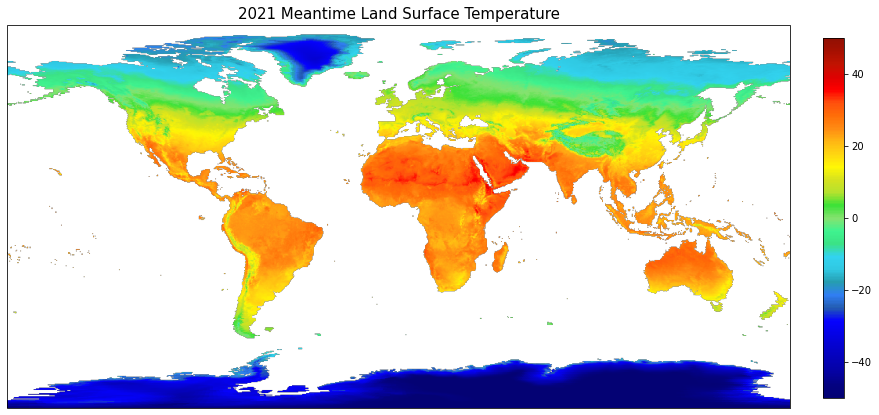

In [15]:
fig = plt.figure(figsize=(15, 10))

# plot the result with cartoee using a PlateCarre projection (default)
ax = cartoee.get_map(lst, region = box)
cb = cartoee.add_colorbar(ax, vis_params=landSurfaceTemperatureVis, loc='right',label=None)

ax.set_title(label='2021 Meantime Land Surface Temperature', fontsize=15)

# ax.coastlines()
plt.savefig(r"C:\Users\Yang Hsiu\Desktop\plot\2021 Meantime Land Surface Temperature.tiff", dpi=200)